## Titanic Challenge: Simple NN
### This is the same workflow as the previous attempts, now playing around with a simple neural network in Keras
#### This model achieved a score of 0.78 on the test set

In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
palette=sns.color_palette('magma')
sns.set(palette=palette)

### Import, Feature Engineering, Cleanup

In [2]:
##Import the data
train = pd.read_csv('/Users/r126l688/Desktop/Professional Development/Kaggle/Titanic/titanic/train.csv')
test = pd.read_csv('/Users/r126l688/Desktop/Professional Development/Kaggle/Titanic/titanic/test.csv')

### Plan of action for cleaning and feature engineering:
1. Drop properties that aren't useful (Ticket) or lack too much data (Cabin)
2. Fill in missing values
3. Extract useful data from existing properties (Title from Name)
4. Dicretize continuous variables (Age and Fare)
5. Map integers onto non-int data
6. Drop redundant properties

#### 1. Drop properties that aren't useful (Ticket) or lack too much data (Cabin)

In [3]:
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)

#### 2. Fill in missing values

In [4]:
#Function to fill in continuous values via ML. In this case, I've used SVM here for funsies
from sklearn.svm import SVR, SVC, LinearSVC #Calling them all because I'll use them later
def svm_num(df,na_col): #pass in the dataset and either Age or Fare
    df=df.copy()
    
    num_df = df.select_dtypes(np.number) 
    val_cols = num_df.loc[:,num_df.isna().sum() == 0].columns
    
    y_train = num_df.loc[num_df[na_col].isna()==False,na_col] 
    X_train = num_df.loc[num_df[na_col].isna()==False,val_cols]
    X_test = num_df.loc[num_df[na_col].isna()==True,val_cols]
    
    svr = SVR()
    svr.fit(X_train,y_train)
    
    y_pred = svr.predict(X_test)
    
    df.loc[df[na_col].isna()==True,na_col] = y_pred
    
    return df

In [5]:
train=svm_num(train,'Age') #Use function to fill in age data in the train set

In [6]:
test=svm_num(test,'Age') #...and the test set

In [7]:
test=svm_num(test,'Fare') #And the missing fare value in the test set

In [8]:
#There are still two missing values for the port of embarcation in the training set. Let's just fill them in with the mode.
port = train.Embarked.dropna().mode()[0]
train['Embarked'] = train['Embarked'].fillna(port)

#### 3. Extract useful data from existing properties (Title from Name)

In [9]:
all_data=[train,test]
for dataset in all_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.')

In [10]:
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

#### 4. Discretize continuous variables (Age and Fare)

In [11]:
#Separate age into categories
all_data=[train,test]
for dataset in all_data:    
    dataset.loc[ dataset['Age'] <= 12, 'Age'] = 0 #Child
    dataset.loc[(dataset['Age'] > 12) & (dataset['Age'] <= 19), 'Age'] = 1 #Teenager
    dataset.loc[(dataset['Age'] > 19) & (dataset['Age'] <= 30), 'Age'] = 2 #Young adult
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 50), 'Age'] = 3 #Adult
    dataset.loc[(dataset['Age'] > 50), 'Age'] = 4 #Older adult
    dataset['Age']=dataset['Age'].astype(int)

In [12]:
#As with age, let's split the continous fare data into discrete categories
all_data=[train,test]
for dataset in all_data:    
    dataset.loc[ dataset['Fare'] <= 10, 'Fare'] = 0 #Low
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 25), 'Fare'] = 1 #Middle
    dataset.loc[(dataset['Fare'] > 25) & (dataset['Fare'] <= 80), 'Fare'] = 2 #High
    dataset.loc[(dataset['Fare'] > 80), 'Fare'] = 3 #Super high
    dataset['Fare']=dataset['Fare'].astype(int)

#### 5. Map integers onto non-int data. So that means Sex, Embarked, and Title.

In [13]:
#Start with the Sex column
all_data=[train,test]
for dataset in all_data: 
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

In [14]:
#Then Embarked...
all_data=[train,test]
for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [15]:
#And finally for Title, filling in those without a title with "0"
all_data=[train,test]
for dataset in all_data:
    dataset['Title'] = dataset['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}).astype(int)
    dataset['Title'] = dataset['Title'].fillna(0)

#### 6. Drop redundant properties. We don't need PassengerID or Name in the datasets anymore.

In [16]:
#However, be sure to stick the test set's PassengerIDs elsewhere to tack it onto the submission file!
test_ids=test['PassengerId']

In [17]:
train = train.drop(['Name','PassengerId'], axis=1)
test = test.drop(['Name','PassengerId'], axis=1)

### ML and Model Evaluation

In [18]:
from sklearn.model_selection import train_test_split
X=train.drop('Survived', axis=1)
y=train['Survived']

In [19]:
#Split into test/training sets for the purpose of initial evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

#### Let's see how many nodes we should add
#### See https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [21]:
X_train.shape

(712, 8)

#### Just going to add one input layer and one output layer---keeping it simple.
#### because it's a binary classification problem, the activation function in the output layer needs to be 'sigmoid' and loss is 'binary_crossentropy'

In [22]:
model = Sequential()
model.add(Dense(units=8,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

2022-04-19 13:42:40.471874: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### define an early stop to monitor loss and put a kibosh on running through too many epochs...

In [23]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

#### ...so I can set an obscene number of epochs and not worry about overfitting

In [24]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=500,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/500
23/23 [==============================] - 0s 6ms/step - loss: 0.8895 - val_loss: 0.7483
Epoch 2/500
23/23 [==============================] - 0s 2ms/step - loss: 0.8821 - val_loss: 0.7277
Epoch 3/500
23/23 [==============================] - 0s 2ms/step - loss: 0.8438 - val_loss: 0.7094
Epoch 4/500
23/23 [==============================] - 0s 2ms/step - loss: 0.7883 - val_loss: 0.6945
Epoch 5/500
23/23 [==============================] - 0s 2ms/step - loss: 0.7663 - val_loss: 0.6803
Epoch 6/500
23/23 [==============================] - 0s 2ms/step - loss: 0.7079 - val_loss: 0.6661
Epoch 7/500
23/23 [==============================] - 0s 2ms/step - loss: 0.6866 - val_loss: 0.6519
Epoch 8/500
23/23 [==============================] - 0s 2ms/step - loss: 0.6698 - val_loss: 0.6372
Epoch 9/500
23/23 [==============================] - 0s 2ms/step - loss: 0.6586 - val_loss: 0.6243
Epoch 10/500
23/23 [==============================] - 0s 2ms/step - loss: 0.6389 - val_loss: 0.6161
Epoch 11/

23/23 [==============================] - 0s 1ms/step - loss: 0.4916 - val_loss: 0.4615
Epoch 84/500
23/23 [==============================] - 0s 2ms/step - loss: 0.4828 - val_loss: 0.4573
Epoch 85/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5006 - val_loss: 0.4546
Epoch 86/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4921 - val_loss: 0.4571
Epoch 87/500
23/23 [==============================] - 0s 1ms/step - loss: 0.5141 - val_loss: 0.4607
Epoch 88/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4906 - val_loss: 0.4587
Epoch 89/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4908 - val_loss: 0.4579
Epoch 90/500
23/23 [==============================] - 0s 1ms/step - loss: 0.5036 - val_loss: 0.4614
Epoch 91/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4939 - val_loss: 0.4632
Epoch 92/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4916 - val_loss: 0.4592
Epoch 93/500


23/23 [==============================] - 0s 1ms/step - loss: 0.4837 - val_loss: 0.4451
Epoch 165/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4652 - val_loss: 0.4449
Epoch 166/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4632 - val_loss: 0.4424
Epoch 167/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4927 - val_loss: 0.4424
Epoch 168/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4762 - val_loss: 0.4419
Epoch 169/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4753 - val_loss: 0.4421
Epoch 170/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4886 - val_loss: 0.4407
Epoch 171/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4708 - val_loss: 0.4406
Epoch 172/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4826 - val_loss: 0.4394
Epoch 173/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4968 - val_loss: 0.4448
Epoc

23/23 [==============================] - 0s 1ms/step - loss: 0.4670 - val_loss: 0.4358
Epoch 246/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4815 - val_loss: 0.4354
Epoch 247/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4608 - val_loss: 0.4339
Epoch 248/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4688 - val_loss: 0.4308
Epoch 249/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4736 - val_loss: 0.4328
Epoch 250/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4859 - val_loss: 0.4348
Epoch 251/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4810 - val_loss: 0.4389
Epoch 252/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4701 - val_loss: 0.4351
Epoch 253/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4621 - val_loss: 0.4336
Epoch 254/500
23/23 [==============================] - 0s 1ms/step - loss: 0.4757 - val_loss: 0.4316
Epoc

#### a li'l noisy, but lookin' good! B)

<AxesSubplot:>

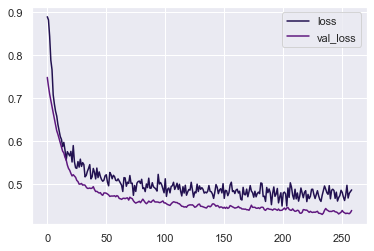

In [25]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [27]:
from sklearn.metrics import classification_report,confusion_matrix

In [28]:
preds = model.predict(X_test)

#### Keras no longer has an option to predict a binary class, so we have to transform the array of probabilities manually by assigning anything below 0.5 to class 0 and above to class 1

In [30]:
preds = np.where(preds > 0.5, 1,0)

#### How'd this bb actually perform?

In [31]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87        99
           1       0.96      0.68      0.79        80

    accuracy                           0.84       179
   macro avg       0.88      0.83      0.83       179
weighted avg       0.87      0.84      0.84       179



In [32]:
print(confusion_matrix(y_test,preds))

[[97  2]
 [26 54]]


#### Not too shabby! Wrap it up!

In [33]:
final_preds = model.predict(test)

In [ ]:
final_preds = pd.DataFrame(np.where(final_preds > 0.5, 1,0), columns=['Survived'])